**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on January 3rd, 2021

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb
import socceraction.atomic.spadl as atomicspadl

## Set up the statsbombloader

In [3]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote, getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
#datafolder = "../data-epl" # Example of local folder with statsbomb data
#SBL = statsbomb.StatsBombLoader(root=datafolder,getter="local")

## Select competitions to load and convert

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 "Women's World Cup"}

In [5]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name == "FIFA World Cup"]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
17,3,43,FIFA World Cup,International,male,2018


In [6]:
# Get matches from all selected competitions
games = list(
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
games = pd.concat(games, sort=True).reset_index(drop=True)
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,785,776,2018-07-01 20:00:00,1,1
1,775,793,2018-06-22 17:00:00,2,0
2,789,769,2018-06-24 20:00:00,0,3
3,785,775,2018-06-16 21:00:00,2,0
4,781,795,2018-06-22 14:00:00,2,0
...,...,...,...,...,...
59,769,778,2018-06-19 14:00:00,1,2
60,771,782,2018-07-10 20:00:00,1,0
61,782,768,2018-07-14 16:00:00,2,0
62,796,774,2018-06-19 20:00:00,3,1


## Load and convert match data

In [7]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [],[]
actions = {}
atomic_actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    # convert data
    actions = statsbomb.convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions)

teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).reset_index(drop=True)

Loading game data: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it]


## Store converted spadl data in a h5-file

In [8]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in atomic_actions.keys():
        spadlstore[f"atomic_actions/game_{game_id}"] = atomic_actions[game_id]

    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()
    spadlstore["atomic_actiontypes"] = atomicspadl.actiontypes_df()

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [9]:
# Select England vs Belgium game at World Cup
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"atomic_actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(spadlstore["atomic_actiontypes"], how="left")
        .merge(spadlstore["bodyparts"], how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7551,0e97b47d-1744-44bd-b6aa-deaa807181a4,1,0.0,790,5625,52.058824,34.430380,73.235294,30.987342,0,1,0,0
1,7551,NaN,1,0.5,790,5607,73.235294,30.987342,72.352941,34.430380,21,1,0,1
2,7551,4621dca4-9a89-4c89-9a24-a8df522a25b8,1,1.0,790,5607,72.352941,34.430380,23.823529,54.227848,0,0,0,2
3,7551,a8139913-47f6-4651-886e-80494672988d,1,3.0,770,3167,24.705882,53.367089,35.294118,66.278481,0,1,0,3
4,7551,7e05afc8-ca26-42d1-8438-4d3e29a86c86,1,5.0,770,3186,35.294118,66.278481,34.411765,65.417722,21,1,0,4


2018-07-14 16:00:00 Belgium 2-0 England 4'


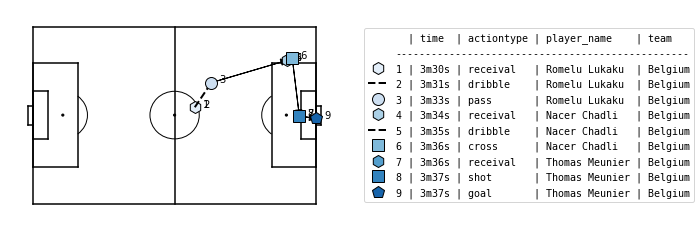

2018-07-14 16:00:00 Belgium 2-0 England 82'


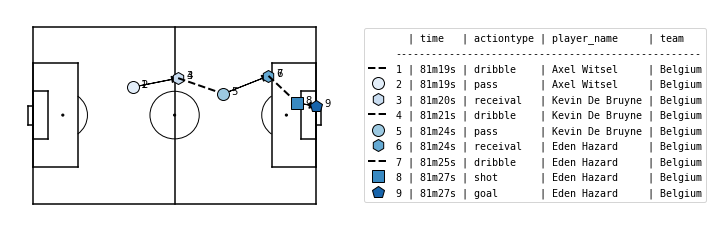

In [10]:
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")].index):
    a = atomic_actions[shot-8:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )